# Genome-wide association study (GWAS)

This notebook demonstrates conducting a genome-wide association study using the public 1000 Genomes dataset stored in BigQuery.  Specifically you will:
* Use the `%%sql` statement to write and execute SQL statements within the notebook
* Extract data from BigQuery and create a local dataset that can be manipulated in Python for visualization and further analysis

Related Links:
* [BigQuery](https://cloud.google.com/bigquery/)
* BigQuery [SQL reference](https://cloud.google.com/bigquery/query-reference)
* [1,000 Genomes Data Description](http://googlegenomics.readthedocs.org/en/latest/use_cases/discover_public_data/1000_genomes.html)
* This notebook is based on the [Google Genomics](https://cloud.google.com/genomics/) BigQuery examples:
    * [GWAS Chi-squared Test](https://github.com/googlegenomics/bigquery-examples/blob/master/1000genomes/sql/gwas-pattern-chi-squared-test.sql)
    * [GWAS z-test](https://github.com/googlegenomics/bigquery-examples/blob/master/1000genomes/sql/gwas-pattern-two-proportion-z-test.sql)

----

NOTE:

* If you're new to notebooks, or want to check out additional samples, check out the full [list](../docs) of general notebooks.
* For additional Genomics samples, check out the full [list](..) of Genomics notebooks.

## Experiment design and dataset construction

In this experiment, we'll be identifying variant positions within chromosome 12 that differ significantly between the case and control groups. The case group for the purposes of this notebook will be individuals from the "EAS" (East Asian) super population.

To work with genomics data stored within BigQuery, we'll import the gcp.bigquery library, which provides a set of high-level wrappers for manipulating SQL within the notebook, issuing queries to BigQuery and translating result sets into Pandas dataframes.

In [1]:
import gcp.bigquery as bq

### Table selection and summary

Variant data from the 1000 genomes dataset is publicly accessible within BigQuery. We can view the schema for the variants table via the gcp.bigquery library.

In [2]:
variants_table = bq.Table('genomics-public-data:1000_genomes.variants')
variants_table.schema

[{ 'name': 'reference_name', 'type': 'STRING', 'mode':'NULLABLE', 'description': 'An identifier from the reference genome or an angle-bracketed ID String pointing to a contig in the assembly file.' },
 { 'name': 'start', 'type': 'INTEGER', 'mode':'NULLABLE', 'description': 'The reference position, with the first base having position 0.' },
 { 'name': 'end', 'type': 'INTEGER', 'mode':'NULLABLE', 'description': 'INFO=<ID=END,Number=1,Type=Integer,Description="End position of the variant described in this record">' },
 { 'name': 'reference_bases', 'type': 'STRING', 'mode':'NULLABLE', 'description': 'Each base must be one of A,C,G,T,N (case insensitive). Multiple bases are permitted. The value in the POS field refers to the position of the first base in the String.' },
 { 'name': 'alternate_bases', 'type': 'STRING', 'mode':'REPEATED', 'description': 'List of alternate non-reference alleles called on at least one of the samples. ("at least one" not true for this dataset)' },
 { 'name': 'quality', 'type': 'FLOAT', 'mode':'NULLABLE', 'description': 'phred-scaled quality score for the assertion made in ALT.' },
 { 'name': 'filter', 'type': 'STRING', 'mode':'REPEATED', 'description': 'PASS if this position has passed all filters, i.e. a call is made at this position. Otherwise, if the site has not passed all filters, a list of codes for filters that fail.' },
 { 'name': 'names', 'type': 'STRING', 'mode':'REPEATED', 'description': 'List of unique identifiers for the variant where available.' },
 { 'name': 'call', 'type': 'RECORD', 'mode':'REPEATED', 'description': 'Per-sample measurements.' },
 { 'name': 'call.call_set_id', 'type': 'STRING', 'mode':'NULLABLE', 'description': 'The id of the callset from which this data was exported from the Google Genomics Variants API.' },
 { 'name': 'call.call_set_name', 'type': 'STRING', 'mode':'NULLABLE', 'description': 'Sample identifier.' },
 { 'name': 'call.genotype', 'type': 'INTEGER', 'mode':'REPEATED', 'description': 'List of genotypes.' },
 { 'name': 'call.phaseset', 'type': 'STRING', 'mode':'NULLABLE', 'description': 'If this value is null, the data is unphased.  Otherwise it is phased.' },
 { 'name': 'call.genotype_likelihood', 'type': 'FLOAT', 'mode':'REPEATED', 'description': 'List of genotype likelihoods.' },
 { 'name': 'call.DP', 'type': 'INTEGER', 'mode':'NULLABLE', 'description': 'FORMAT=<ID=DP,Number=1,Type=Integer,Description="# high-quality bases">' },
 { 'name': 'call.DS', 'type': 'FLOAT', 'mode':'NULLABLE', 'description': 'FORMAT=<ID=DS,Number=1,Type=Float,Description="Genotype dosage from MaCH/Thunder">' },
 { 'name': 'call.FT', 'type': 'STRING', 'mode':'NULLABLE', 'description': 'None' },
 { 'name': 'call.GQ', 'type': 'STRING', 'mode':'NULLABLE', 'description': 'FORMAT=<ID=GQ,Number=1,Type=Float,Description="Genotype quality">' },
 { 'name': 'call.PL', 'type': 'INTEGER', 'mode':'REPEATED', 'description': 'FORMAT=<ID=PL,Number=.,Type=Integer,Description="List of Phred-scaled genotype likelihoods, number of values is (#ALT+1)*(#ALT+2)/2">' },
 { 'name': 'call.SP', 'type': 'INTEGER', 'mode':'NULLABLE', 'description': 'FORMAT=<ID=SP,Number=1,Type=Integer,Description="Phred-scaled strand bias P-value">' },
 { 'name': 'AA', 'type': 'STRING', 'mode':'NULLABLE', 'description': 'INFO=<ID=AA,Number=1,Type=String,Description="Ancestral Allele, ftp://ftp.1000genomes.ebi.ac.uk/vol1/ftp/pilot_data/technical/reference/ancestral_alignments/README">' },
 { 'name': 'AC', 'type': 'INTEGER', 'mode':'REPEATED', 'description': 'INFO=<ID=AC,Number=.,Type=Integer,Description="Alternate Allele Count">' },
 { 'name': 'AC1', 'type': 'INTEGER', 'mode':'NULLABLE', 'description': 'INFO=<ID=AC1,Number=1,Type=Float,Description="Max-likelihood estimate of the first ALT allele count (no HWE assumption)">' },
 { 'name': 'AF', 'type': 'FLOAT', 'mode':'NULLABLE', 'description': 'INFO=<ID=AF,Number=1,Type=Float,Description="Global Allele Frequency based on AC/AN">' },
 { 'name': 'AF1', 'type': 'FLOAT', 'mode':'NULLA

### Classifying per-call variant positions into variant/non-variant groups

We can tally the reference/alternate allele accounts for *individual* variant positions within chromosome 12. The field `call.genotype` is an integer ranging from `[-1, num_alternate_bases]`. 
* A value of negative one indicates that the genotype for the call is ambiguous (i.e., a no-call).
* A value of zero indicates that the genotype for the call is the same as the reference (i.e., non-variant). 
* A value of one would indicate that the genotype for the call is the 1st value in the list of alternate bases (likewise for values >1).

In [3]:
%%sql --module allele_counts

SELECT 
    reference_name,
    start,
    reference_bases,
    alternate_bases,
    end,
    vt,    
    call.call_set_name AS call_set_name,
    (0 = first_allele) + (0 = second_allele) AS ref_count,
    (1 = first_allele) + (1 = second_allele) AS alt_count,    
FROM
  FLATTEN((
    SELECT
      reference_name,
      start,
      reference_bases,
      alternate_bases,
      end,
      vt,
      call.call_set_name,
      NTH(1, call.genotype) WITHIN call AS first_allele,
      NTH(2, call.genotype) WITHIN call AS second_allele,
    FROM
      $variants_table
    WHERE
      reference_name = '12' -- i.e., chromosome 12
    HAVING
      -- Exclude calls _where one _or both alleles were NOT called (-1)
      0 <= first_allele
      AND 0 <= second_allele
    ),
    call)

Let's verify that our allele counts match our expectations before moving on. For any given row, the alternate + reference counts should sum to 2 for this experiment.

In [4]:
bq.Query(allele_counts, variants_table=variants_table).sample()

job_lE02MaoIYoNCxaH-MCyer9SEx-I (0.5s, cached) rows: 5

### Assigning case and control groups

Now we can join our allele counts with metadata available in the sample info table. We'll use this sample metadata to split the set of genomes into case and control groups based upon the super population group.

In [5]:
sample_info_table = bq.Table('genomics-public-data:1000_genomes.sample_info')

In [6]:
%%sql --module exp_groups

SELECT
  super_population,
  ('EAS' = super_population) AS is_case,
  call_set_name,
  reference_name,
  start,
  reference_bases,
  alternate_bases,
  end,
  vt,
  ref_count,
  alt_count,
FROM $allele_counts AS allele_counts
JOIN $sample_info_table AS samples
  ON allele_counts.call_set_name = samples.sample

In [7]:
bq.Query(exp_groups, allele_counts=allele_counts,
                     sample_info_table=sample_info_table,
                     variants_table=variants_table).sample()

job_bKSsVBpOlgdeto2wSNyP2qIZbfo (0.7s, cached) rows: 5

The variants table contains a few different types of variant: structural variants ("SV"), indels ("INDEL") and SNPs ("SNP").

In [8]:
%%sql
SELECT 
  vt,
  COUNT(*)
FROM $exp_groups
GROUP BY vt

job_9saPltcVnA6H3C5t0TuZrMh3LhE (0.6s, cached) rows: 3

For the purposes of this experiment, let's limit the variants to only SNPs.

In [9]:
%%sql --module snps
SELECT * 
FROM $exp_groups
WHERE vt='SNP'

In [10]:
bq.Query(snps,
         exp_groups=exp_groups,
         allele_counts=allele_counts,
         sample_info_table=sample_info_table,
         variants_table=variants_table).sample()

job_nnOp76BD5JDozhStbGn4I0YDyTM (0.6s, cached) rows: 5

### Tallying reference/alternate allele counts for case/control groups

Now that we've assigned each call set to either the case or the control group, we can tally up the counts of reference and alternate alleles within each of our assigned case/control groups, for each variant position, like so:

In [11]:
%%sql --module grouped_counts

SELECT
    reference_name,
    start,
    end,
    reference_bases,
    alternate_bases,
    vt,
    SUM(ref_count + alt_count) AS allele_count,
    SUM(ref_count) AS ref_count,
    SUM(alt_count) AS alt_count,
    SUM(IF(TRUE = is_case,
        INTEGER(ref_count + alt_count),
        0)) AS case_count,
    SUM(IF(FALSE = is_case,
        INTEGER(ref_count + alt_count),
        0)) AS control_count,
    SUM(IF(TRUE = is_case,
        ref_count,
        0)) AS case_ref_count,
    SUM(IF(TRUE = is_case,
        alt_count,
        0)) AS case_alt_count,
    SUM(IF(FALSE = is_case,
        ref_count,
        0)) AS control_ref_count,
    SUM(IF(FALSE = is_case,
        alt_count,
        0)) AS control_alt_count
FROM $snps
GROUP BY
    reference_name,
    start,
    end,
    reference_bases,
    alternate_bases,
    vt

Again, validate that the results are sensical for the group level counts (still per variant position).

In [12]:
bq.Query(grouped_counts,
         snps=snps,
         exp_groups=exp_groups,
         allele_counts=allele_counts,
         sample_info_table=sample_info_table,
         variants_table=variants_table).sample()

job_DBirnO5cAKUptOxA6LBrRZi0npM (0.5s, cached) rows: 5

## Quantify the statistical significance at each variant positions

We can quantify the statistical significance of each variant position using the Chi-squared test. Furthermore, we can restrict our result set to *only* statistically significant variant positions for this experiment by ranking each position by its statistical signficance (decreasing) and thresholding the results for significance at `p <= 5e-8` (chi-squared score >= 29.7).

In [13]:
%%sql --module results

SELECT
  reference_name,
  start,
  end,
  reference_bases,
  alternate_bases,
  vt,
  case_count,
  control_count,
  allele_count,
  ref_count,
  alt_count,
  case_ref_count,
  case_alt_count,
  control_ref_count,
  control_alt_count,
  ROUND(
    POW(case_ref_count - (ref_count/allele_count)*case_count,
      2)/((ref_count/allele_count)*case_count) +
    POW(control_ref_count - (ref_count/allele_count)*control_count,
      2)/((ref_count/allele_count)*control_count) +
    POW(case_alt_count - (alt_count/allele_count)*case_count,
      2)/((alt_count/allele_count)*case_count) +
    POW(control_alt_count - (alt_count/allele_count)*control_count,
      2)/((alt_count/allele_count)*control_count),
    3)
  AS chi_squared_score
FROM $grouped_counts
WHERE
  # For chi-squared, expected counts must be at least 5 for each group
  (ref_count/allele_count)*case_count >= 5.0
  AND (ref_count/allele_count)*control_count >= 5.0
  AND (alt_count/allele_count)*case_count >= 5.0
  AND (alt_count/allele_count)*control_count >= 5.0
HAVING
  # Chi-squared critical value for df=1, p-value=5*10^-8 is 29.71679
  chi_squared_score >= 29.71679
ORDER BY
  chi_squared_score DESC,
  allele_count DESC

A quick sanity check of the results reveals that the positions deemed significant do in fact have significantly different case/control counts for the alternate/reference bases.

In [14]:
bq.Query(results,
         grouped_counts=grouped_counts,
         snps=snps,
         exp_groups=exp_groups,
         allele_counts=allele_counts,
         sample_info_table=sample_info_table,
         variants_table=variants_table).sample()

job_XLICyb3xX1EBlGTuWwWF5x9RZP0 (0.5s, cached) rows: 5

### Computing Chi-squared statistics in BigQuery vs Python vs R

Let's compare these BigQuery-computed Chi-squared scores to ones calculated via Python's statistical packages

In [15]:
import numpy as np
from scipy.stats import chi2_contingency

chi2, p, dof, expected = chi2_contingency(np.array([ 
    [220, 352], # case 
    [1593, 19]  # control
]))

print 'Python Chi-sq score = %.3f' % chi2
print 'BigQuery was 1090.781'

Python Chi-sq score = 1086.505
BigQuery was 1090.781


Comparing Python statistics to those computed in R
```
> chisq.test(rbind(c(220, 352), c(1593, 19)))

	Pearson's Chi-squared test with Yates' continuity correction

data:  rbind(c(220, 352), c(1593, 19))
X-squared = 1086.505, df = 1, p-value < 2.2e-16
```

In [16]:
%%sql --module top1k_snps
SELECT
  chi_squared_score,
  control_ref_count,
  control_alt_count,
  case_ref_count,
  case_alt_count
FROM $results
LIMIT 1000

In [17]:
chisq_df = bq.Query(top1k_snps, 
                    results=results,
                    grouped_counts=grouped_counts,
                    snps=snps,
                    exp_groups=exp_groups,
                    allele_counts=allele_counts,
                    sample_info_table=sample_info_table,
                    variants_table=variants_table).to_dataframe()
chisq_df.shape
chisq_df.ix[1]

chi_squared_score    1076.666
control_ref_count    1473.000
control_alt_count     139.000
case_ref_count        116.000
case_alt_count        456.000
Name: 1, dtype: float64

In [18]:
for i in xrange(len(chisq_df)):
    # construct a contingency table for the reference/alternate allele counts
    ctable = np.array([
        [chisq_df.ix[i]['case_ref_count'],    chisq_df.ix[i]['case_alt_count']],
        [chisq_df.ix[i]['control_ref_count'], chisq_df.ix[i]['control_alt_count']]])
    
    py_chi2, pvalue, dof, expected = chi2_contingency(ctable)
    bq_chi2 = chisq_df.ix[i]['chi_squared_score']
    print 'BQ: %.3f, SciPy: %.3f: delta=%.3f' % (bq_chi2, py_chi2, abs(bq_chi2 - py_chi2))


BQ: 1090.781, SciPy: 1086.505: delta=4.276
BQ: 1076.666, SciPy: 1073.082: delta=3.584
BQ: 1071.835, SciPy: 1068.266: delta=3.569
BQ: 1068.856, SciPy: 1065.294: delta=3.562
BQ: 1046.758, SciPy: 1043.029: delta=3.729
BQ: 1041.396, SciPy: 1037.664: delta=3.732
BQ: 1035.231, SciPy: 1031.721: delta=3.510
BQ: 1033.299, SciPy: 1029.576: delta=3.723
BQ: 1025.179, SciPy: 1021.494: delta=3.685
BQ: 1022.474, SciPy: 1019.082: delta=3.392
BQ: 1017.172, SciPy: 1013.468: delta=3.704
BQ: 1011.200, SciPy: 1007.545: delta=3.655
BQ: 1011.200, SciPy: 1007.545: delta=3.655
BQ: 1011.200, SciPy: 1007.545: delta=3.655
BQ: 1009.720, SciPy: 1006.322: delta=3.398
BQ: 1007.764, SciPy: 1004.401: delta=3.363
BQ: 1005.137, SciPy: 1001.780: delta=3.357
BQ: 1003.169, SciPy: 999.524: delta=3.645
BQ: 1000.886, SciPy: 997.425: delta=3.461
BQ: 999.162, SciPy: 995.522: delta=3.640
BQ: 999.162, SciPy: 995.522: delta=3.640
BQ: 999.162, SciPy: 995.522: delta=3.640
BQ: 992.621, SciPy: 988.998: delta=3.623
BQ: 989.933, SciPy: 9

## Analyzing the GWAS results

First, how many statistically significant variant positions did we find?

In [19]:
%%sql 
SELECT COUNT(*) AS num_significant_snps
FROM $results

job_zW1d0rk3afiOD_PQtKVHQlZzOkE (0.5s, cached) rows: 1

We now have a dataset that is sufficiently small to fit into memory on our instance, so let's pull the top 1000 SNP positions locally. Since we only need a subset of the columns, we can project our data first to remove unneeded columns.

In [20]:
%%sql --module sig_snps_dataset
SELECT * FROM (
    SELECT
      reference_name
      , start
      , reference_bases
      , alternate_bases
      , chi_squared_score
    FROM $results
    LIMIT 1000
)
ORDER BY start asc

In [21]:
sig_snps = bq.Query(sig_snps_dataset, 
                    results=results,
                    grouped_counts=grouped_counts,
                    snps=snps,
                    exp_groups=exp_groups,
                    allele_counts=allele_counts,
                    sample_info_table=sample_info_table,
                    variants_table=variants_table).to_dataframe()
sig_snps[:10]

,reference_name,start,reference_bases,alternate_bases,chi_squared_score
0,12,1595431,A,G,747.021
1,12,1600977,A,T,831.900
2,12,2129565,C,T,714.980
3,12,2132494,T,C,757.336
4,12,2134197,A,G,826.659
5,12,2138687,C,A,709.524
6,12,2139264,A,C,772.951
7,12,2140624,T,C,708.078
8,12,2141908,C,T,793.613
9,12,6505528,T,G,772.551


Let's visualize the distribution of significant SNPs along the length of the chromosome. The y-value of the charts indicates the Chi-squared score: larger values are more significant.

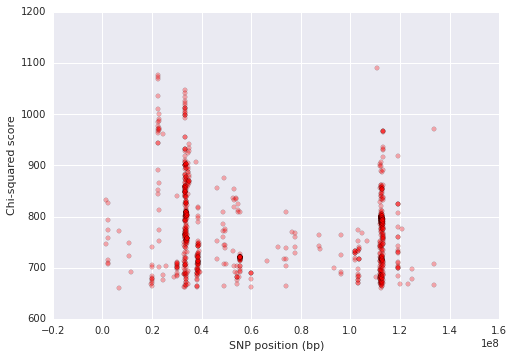

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns

#g = sns.distplot(sig_snps['start'], rug=False, hist=False, kde_kws=dict(bw=0.1))
fig, ax = plt.subplots()
ax.scatter(sig_snps['start'], sig_snps['chi_squared_score'], alpha=0.3, c='red')
ax.set_ylabel('Chi-squared score')
ax.set_xlabel('SNP position (bp)')

Let's zoom in on one region that contains a large number of very significant SNPs:

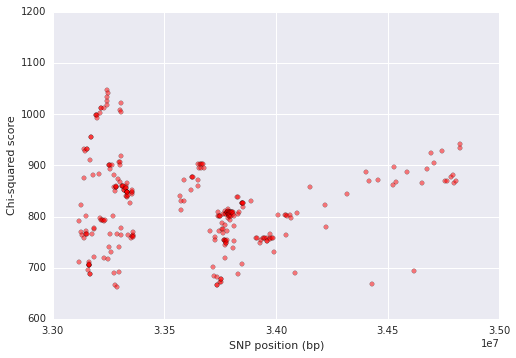

In [23]:
fig, ax = plt.subplots()
ax.scatter(sig_snps['start'], sig_snps['chi_squared_score'], alpha=0.5, c='red')
ax.set_xlim([3.3e7, 3.5e7])
ax.set_ylabel('Chi-squared score')
ax.set_xlabel('SNP position (bp)')

## Further exploration of statistically significant variant positions

We can take our analysis further by mapping selected variant positions back to the chromosome and visualizing call sets and reads. Let's retrieve the top SNP identified when ranked by the Chi-squared score:

In [24]:
%%sql --module top_snp
SELECT start
FROM $sig_snps_dataset
ORDER BY chi_squared_score desc
LIMIT 1

In [25]:
bq.Query(top_snp,
         sig_snps_dataset=sig_snps_dataset,
         results=results,
         grouped_counts=grouped_counts,
         snps=snps,
         exp_groups=exp_groups,
         allele_counts=allele_counts,
         sample_info_table=sample_info_table,
         variants_table=variants_table).results()

job_dTFN5ipSKZmu7kyrTR9aMEsHhR8 (0.5s, cached) rows: 1

Grab an arbitrary set of 10 callset IDs for rendering in the genome browser.

In [26]:
%%sql --module callset_ids
SELECT * FROM (
  SELECT call.call_set_id AS callset_id
  FROM $variants_table
  GROUP BY callset_id)
LIMIT 10

In [27]:
callsets_df = bq.Query(callset_ids, variants_table=variants_table).to_dataframe()
callsets = list(callsets_df['callset_id'])

In [28]:
from IPython.display import HTML
def gabrowse(dataset, reference_name, start_position, callset_ids):
    callsets_query_params = ''.join('&callsetId=%s&cBackend=GOOGLE' % callset_id for callset_id in callset_ids)
    url = ('https://gabrowse.appspot.com/#=&backend=GOOGLE&location=12%3A'
         + str(start_position)
         + callsets_query_params)
    return HTML('<iframe src="%s" width=1024 height=800></iframe>' % url)

Now we can render the call sets and reads for the selected SNP position by embedding the GABrowse application directly in our notebook.

In [29]:
gabrowse('1000genomes', '12', 110571373, callsets)

# Summary

This notebook illustrated how to conduct a GWAS experiment using variant data stored within the Google Genomics BigQuery tables, retrieve a local copy of the top results and visualize the data with Python libraries.